# Assignment 6: Autoencoder and Variational Autoencoder (Solution)
---

In this assignment, we will train an autoencoder that can denoise images in the CIFAR10 dataset ([link](https://en.wikipedia.org/wiki/CIFAR-10)).

In addition, we will train a variational autoencoder that can learn a distribution of low-dimensional representation of the MNIST dataset ([link](https://en.wikipedia.org/wiki/MNIST_database)). The distribution can be later used to sample new, "fake" images.  

---
## Exercise 1-1. Autoencoder

Let's start by importing the necessary packages.

                    import random
                    import numpy as np
                    import matplotlib.pyplot as plt

                    import tensorflow as tf 
                    from tensorflow import keras 
                    from keras.datasets import mnist, cifar10
                    from keras.models import Sequential

                    from keras import Model
                    from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dense, Flatten, Reshape, Input


Next, let's set some seeds for experiment reproducibility.

                    SEED = 99
                    random.seed(SEED)
                    np.random.seed(SEED)
                    tf.random.set_seed(SEED)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras 
from keras.datasets import mnist, cifar10
from keras.models import Sequential

from keras import Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dense, Flatten, Reshape, Input

In [ ]:
# Set seeds
SEED = 99
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Next, let's do the following.

- Load the CIFAR 10 dataset, store values in `x_train`, `y_train`, `x_test`, `y_test`, respectively. 
- Randomly sample a subset of `x_train` and `x_test` to match the following shape.
  - x_train.shape = (15000, 32, 32, 3) 
  - x_test.shape = (1000, 32, 32, 3) 
  - Reference ([link](https://docs.python.org/3/library/random.html#random.sample))


In [ ]:
(x_train, _), (x_test, _) = cifar10.load_data()

# Before sampling 
print(f"Train, shape = {x_train.shape}")
print(f"Test, shape = {x_test.shape}")

# For the purposes of class select a subset of the dataset
TRAIN_PERMUTATION = random.sample(range(0, x_train.shape[0]), 15000) # 15000 for train
TEST_PERMUTATION = random.sample(range(0, x_test.shape[0]), 1000) # 1000 for test

x_train = x_train[TRAIN_PERMUTATION]
x_test = x_test[TEST_PERMUTATION]

# After sampling
print(f"Train, shape = {x_train.shape}")
print(f"Test, shape = {x_test.shape}")

Train, shape = (50000, 32, 32, 3)
Test, shape = (10000, 32, 32, 3)
Train, shape = (15000, 32, 32, 3)
Test, shape = (1000, 32, 32, 3)


Next, let's normalize `x_train` and `x_test` and set input shape using the following code.  

                    x_train = x_train.astype('float32')/ 255.
                    x_test = x_test.astype('float32')/ 255.

                    input_shape = (x_train.shape[1], x_train.shape[2], 3)

In [ ]:
# Nrmalize and set datatype
x_train = x_train.astype('float32')/ 255.
x_test = x_test.astype('float32')/ 255.

input_shape = (x_train.shape[1], x_train.shape[2], 3)
print(input_shape)

(32, 32, 3)



## Exercise 1-2

- Fill in the line with your code below using `numpy.random.normal` to sample a gaussian noise of `mean` and `std` specified
- Make sure the size of the noise is same as the size of `input_data`  
- Reference ([link](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html))

                    def add_noise(input_data):
                      mean , std = 0.0, 0.15 
                      noise = ################# YOUR CODE HERE ##################
                      noisy_data = np.clip(input_data + noise, 0., 1.) 
                      return noisy_data

In [ ]:
# Write a function to add gaussian noise
def add_noise(input_data):
  # Mean and standard deviation of the noise to be added
  mean , std = 0.0, 0.15 
  noise = np.random.normal(mean, std, size = input_data.shape)
  # Clip data so that it does not violate normalization ranges
  noisy_data = np.clip(input_data + noise, 0., 1.) 
  return noisy_data

Next, call the function you just wrote and plot noisy and clean images side by side. 

                    noisy_x_train = add_noise(x_train)
                    noisy_x_test = add_noise(x_test)

                    fig, ax = plt.subplots(4,4,figsize = (12,12), dpi = 80)
                    for i, ax in enumerate(fig.axes):
                      if i%2 ==0 :  
                        ax.imshow(np.squeeze(x_train[i]))
                        ax.set_title(f"Clean")
                      else: 
                        ax.imshow(np.squeeze(noisy_x_train[i-1]))
                        ax.set_title("Noisy")

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153232811-6167c633-171c-4093-b31e-c2ec78a39338.png")
"/>
</p>

<p align="center">
  <em>Figure 1: exampe of clean and noisy images.</em>
</p>



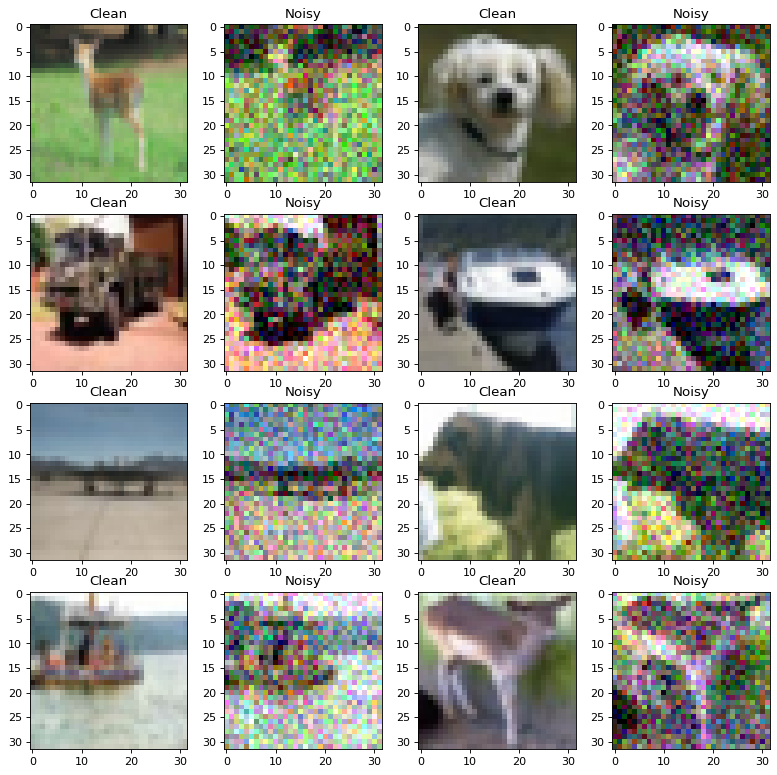

In [ ]:
# use the add noise function
noisy_x_train = add_noise(x_train)
noisy_x_test = add_noise(x_test)

fig, ax = plt.subplots(4,4,figsize = (12,12), dpi = 80)
for i, ax in enumerate(fig.axes):
  if i%2 ==0 :  
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title(f"Clean")
  else: 
    ax.imshow(np.squeeze(noisy_x_train[i-1]))
    ax.set_title("Noisy")

The architecture of an autoencoder consists of two parts, the encoder and the decoder. We will be coding both parts in a single model called `autoencoder`.


## Exercise 1-3

- Initialize a Sequential model with following code 

                  autoencoder = Sequential()

- Use `model.add()` function to build an autoencoder with the following architecture. Use `padding='same'` for all layers.

  - 1st layer: convolutional layer with `28` filters, kernel size `3` by `3`, activation function ReLU
  - 2nd layer: pooling layer with max pooling and pooling size `2` by `2`
  - 3rd layer: convolutional layer with `28` filters, kernel size `3` by `3`, activation function ReLU
  - 4th layer: pooling layer with max pooling and pooling size `2` by `2`.
  This completes the encoder part
  - 5th layer: inverse convolution (Conv2DTranspose) layer with `28` filters, kernel size `3` by `3`, stride of `2` and activation function ReLU
  - 6th layer: inverse convolution (Conv2DTranspose) layer with `28` filters, kernel size `3` by `3`, stride of `2` and activation function ReLU
  - 7th layer: convolutional layer with `3` filters, kernel size `3` by `3`, activation function sigmoid

- Use `autoencoder.summary()` to check the built CNN encoder.

- References 
  - Conv2D ([link](https://keras.io/api/layers/convolution_layers/convolution2d/)) 
  - MaxPool ([link](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
  - Conv2DTranspose ([link](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/))


In [ ]:
"""
Define the AE model structure
"""
autoencoder = Sequential() 
# Encoder
autoencoder.add(Conv2D(28, (3, 3), activation='relu', padding='same', input_shape = input_shape))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(28, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Latent representation, shape = ?
# Decoder
autoencoder.add(Conv2DTranspose(28, (3, 3), strides = 2, activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(28, (3, 3), strides = 2, activation='relu', padding='same'))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 28)        784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 28)        7084      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 28)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 28)       7084      
 nspose)                                                         
                                                        

Now, compile and fit the autoencoder. 

                    autoencoder.compile(optimizer='adam', loss='mse')

                    autoencoder.fit(noisy_x_train, x_train,
                                    epochs = 20,
                                    batch_size = 256, 
                                    shuffle = True,
                                    verbose =2)

Notice that the input data for training is `x_train`, `x_train`. Why is this the case? PS. expect a training time about 11 minutes. 

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(noisy_x_train, x_train,
                epochs = 15,
                batch_size = 256, 
                shuffle = True,
                verbose =2)

Epoch 1/15
59/59 - 47s - loss: 0.0372 - 47s/epoch - 794ms/step
Epoch 2/15
59/59 - 48s - loss: 0.0159 - 48s/epoch - 810ms/step
Epoch 3/15
59/59 - 44s - loss: 0.0127 - 44s/epoch - 753ms/step
Epoch 4/15
59/59 - 44s - loss: 0.0098 - 44s/epoch - 745ms/step
Epoch 5/15
59/59 - 45s - loss: 0.0090 - 45s/epoch - 755ms/step
Epoch 6/15
59/59 - 47s - loss: 0.0084 - 47s/epoch - 803ms/step
Epoch 7/15
59/59 - 50s - loss: 0.0081 - 50s/epoch - 846ms/step
Epoch 8/15
59/59 - 45s - loss: 0.0078 - 45s/epoch - 759ms/step
Epoch 9/15
59/59 - 45s - loss: 0.0075 - 45s/epoch - 762ms/step
Epoch 10/15
59/59 - 45s - loss: 0.0074 - 45s/epoch - 755ms/step
Epoch 11/15
59/59 - 46s - loss: 0.0072 - 46s/epoch - 775ms/step
Epoch 12/15
59/59 - 45s - loss: 0.0070 - 45s/epoch - 759ms/step
Epoch 13/15
59/59 - 44s - loss: 0.0069 - 44s/epoch - 751ms/step
Epoch 14/15
59/59 - 44s - loss: 0.0066 - 44s/epoch - 750ms/step
Epoch 15/15
59/59 - 44s - loss: 0.0064 - 44s/epoch - 752ms/step


Let's save the model for future use. 

                    autoencoder.save("my_denoiser")

Load the saved model and plot noise/denoised `test` images.  

                    loaded_model = keras.models.load_model("my_denoiser")
                    denoised_x_test= loaded_model.predict(x_test)

                    fig, ax = plt.subplots(6,3,figsize = (8,19), dpi = 80)
                    for i, ax in enumerate(fig.axes):
                      if i%3 ==0 :  
                        ax.imshow(np.squeeze(x_test[i]))
                        ax.set_title(f"Clean")
                      elif i%3==1:
                        ax.imshow(np.squeeze(noisy_x_test[i-1]))
                        ax.set_title("Noisy")
                      else: 
                        ax.imshow(np.squeeze(denoised_x_test[i-2]))
                        ax.set_title("AE Denoised")


<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/154810843-58481cea-10b9-4f20-bc71-f78332d16e14.png")
"/>
</p>

<p align="center">
  <em>Figure 2: Clean, Noisy and Denoised images</em>
</p>


In [ ]:
# save 
autoencoder.save("my_denoiser")

INFO:tensorflow:Assets written to: my_denoiser/assets


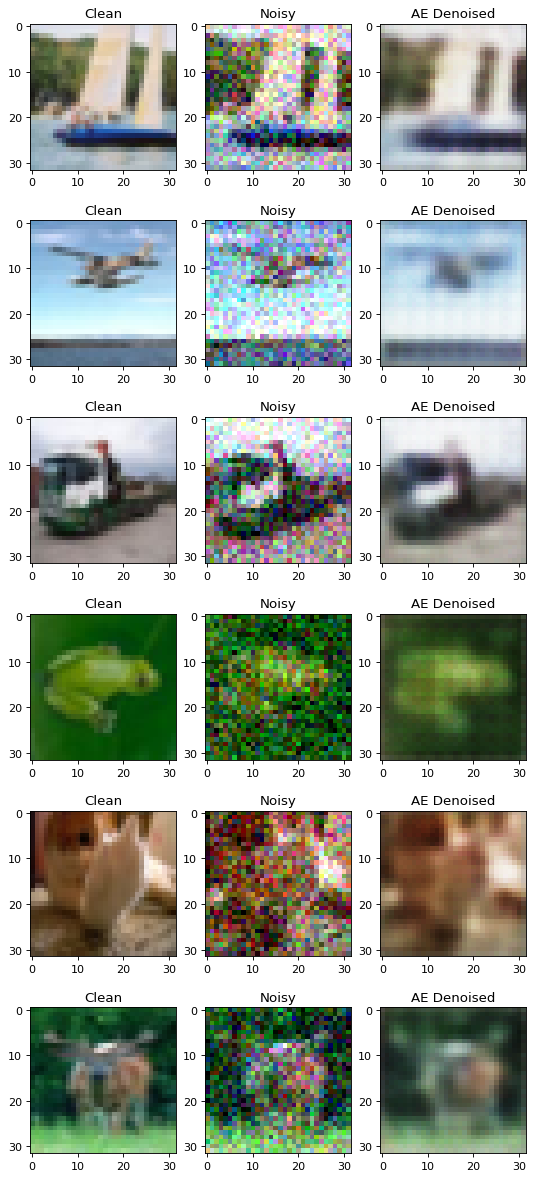

In [ ]:
# load and denoise on test set
loaded_model = keras.models.load_model("my_denoiser")

denoised_x_test= loaded_model.predict(x_test)

# plot the denoised set
fig, ax = plt.subplots(6,3,figsize = (8,19), dpi = 80)
for i, ax in enumerate(fig.axes):

  if i%3 ==0 :  
    ax.imshow(np.squeeze(x_test[i]))
    ax.set_title(f"Clean")
  elif i%3==1:
    ax.imshow(np.squeeze(noisy_x_test[i-1]))
    ax.set_title("Noisy")
  else: 
    ax.imshow(np.squeeze(denoised_x_test[i-2]))
    ax.set_title("AE Denoised")

---
## Exercise 2. Variational Autoencoder (VAE)

Instead of directly learning the latent features from input samples, a VAE learns the distribution of latent features. This gives us the ability to sample "new" images from a learned distribution. We will be reducing the images from the MNIST dataset to a vector of just two dimensions (x, y). Then, we can take a random vector, for eample (2.5, 0.5), to generate an image.   


## Exercise 2-1
- load `mnist` data to `x_train`, `x_test`, `y_train`, `y_test`
- reshape `x_train` (`x_train.shape[0]`, `28`, `28`, `1`) 
- change type of x_train to `float32` and normalize pixel values to `[0, 1]`

In [ ]:
# Load
(x_train, _), (x_test, _) = mnist.load_data()

# Set type and normalize
x_train = x_train.reshape(x_train.shape[0], 28,28,1).astype('float32')/255.

- Unlike autoencoder, in VAE, we will create disjoint Encoder, Decoder, and Sampling layers. The three components will be stitched together later.  

- Use the following code to set input shape, set latent dimensions, and implement a custom sampling layer. 

                input_shape = (x_train.shape[1], x_train.shape[2], 1)
                latent_dims = 2

                class Sampling(keras.layers.Layer):
                  def call(self, distribution):
                    mean, log_variance = distribution 
                    sample = tf.keras.backend.random_normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1] ) )
                    return mean + tf.exp(0.5*log_variance)*sample  # mean + std

In [ ]:
# Set the input shape for MNIST
input_shape = (x_train.shape[1], x_train.shape[2], 1)

# Number of "latent" dimensions to which we want to reduce digits to
latent_dims = 2

# Implement out own layer
class Sampling(keras.layers.Layer):
  def call(self, distribution):
    mean, log_variance = distribution

    # Sample a standard normal distribution 
    sample = tf.keras.backend.random_normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1] ) )

    # Return a latent encoding
    return mean + tf.exp(0.5*log_variance)*sample  # mean + std

Use the following code to build an encoder. 

                    encoder_input = Input(shape = input_shape)

                    x = Conv2D(32, (3, 3), activation = "relu", strides=2)(encoder_input)
                    x = Conv2D(64, (3, 3), activation = "relu", strides = 2)(x)
                    x = Flatten()(x)
                    x = Dense(16, activation = "relu")(x)

                    mean = Dense(latent_dims)(x)
                    variance = Dense(latent_dims)(x)
                    encoded_input = Sampling()([mean, variance])

                    encoder = Model(encoder_input, [mean, variance, encoded_input], name = "encoder")
                    encoder.summary()

In [ ]:
encoder_input = Input(shape = input_shape)

x = Conv2D(32, (3, 3), activation = "relu", strides=2)(encoder_input)
x = Conv2D(64, (3, 3), activation = "relu", strides = 2)(x)
x = Flatten()(x)
x = Dense(16, activation = "relu")(x)

# Get distribution statistics
mean = Dense(latent_dims)(x)
variance = Dense(latent_dims)(x)
encoded_input = Sampling()([mean, variance])

encoder = Model(encoder_input, [mean, variance, encoded_input], name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 13, 13, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 6, 6, 64)     18496       ['conv2d_3[0][0]']               
                                                                                                  
 flatten (Flatten)              (None, 2304)         0           ['conv2d_4[0][0]']               
                                                                                            

Use the following code to build a decoder.  

                    decoder_input = keras.Input(shape = (latent_dims,))

                    x = Dense(7*7*64, activation = "relu")(decoder_input)
                    x =  Reshape((7,7,64))(x)
                    x = Conv2DTranspose(64, (3,3), activation = "relu", strides = 2, padding="same")(x)
                    x = Conv2DTranspose(32, (3,3), activation = "relu", strides = 2, padding = "same")(x)
                    reconstructed_img = Conv2DTranspose(1, (3,3),  activation = "sigmoid", padding = "same")(x)

                    decoder = keras.Model(decoder_input, reconstructed_img, name = "decoder")
                    decoder.summary()

In [ ]:
decoder_input = keras.Input(shape = (latent_dims,))

# When specifying input_shape, we dont care about batch 
# project it back to 3136 shape
x = Dense(7*7*64, activation = "relu")(decoder_input)

# convert to a rectangle
x =  Reshape((7,7,64))(x)

# Inverse Convolutions 
x = Conv2DTranspose(64, (3,3), activation = "relu", strides = 2, padding="same")(x)
x = Conv2DTranspose(32, (3,3), activation = "relu", strides = 2, padding = "same")(x)
reconstructed_img = Conv2DTranspose(1, (3,3),  activation = "sigmoid", padding = "same")(x)

decoder = keras.Model(decoder_input, reconstructed_img, name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 1)        289 

The loss function of VAE combines the reconstruction loss as well as the KL-Divergence term. In the following, we will import some the loss function and stitch the encoder and decoder together.

In [ ]:
# Get some hosted files
!wget -o -q https://github.com/poudel-bibek/Intro-to-AI-Assignments/files/8026719/custom_vae.zip
!unzip -o -q ./custom_vae -d ./custom_modules/

# Contains a custom loss function implementation and stitches encoder and decoder
from custom_modules.custom_vae import VAE

vae = VAE(encoder, decoder)


## Exercise 2-2

Fill in the function below with your code to do the following: 
- compile `vae` with `adam` optimizer 
- fit `vae` to `x_train` (NOT `x_train`, `x_train`) for `30` epochs
- use batch size of `128` and set shuffle to `True` 

                    def training(vae, train_now):

                      if train_now:
                        ############ YOUR CODE HERE (1) ############
                        ############ YOUR CODE HERE (2) ############

                        vae.decoder.save("my_decoder")
                        trained_vae_decoder = tf.keras.models.load_model("my_decoder")
                      else: 
                        # Get the hosted trained model
                        !wget -o -q https://github.com/poudel-bibek/Intro-to-AI-Assignments/files/8102846/my_trained_vae_decoder.zip
                        !unzip -o -q ./my_trained_vae_decoder.zip -d unzipped/ 
                        trained_vae_decoder = tf.keras.models.load_model('./unzipped/my_trained_vae_decoder')

                      return trained_vae_decoder

- Reference: Compile and fit ([link](https://keras.io/api/models/model_training_apis/))


In [ ]:
def training(vae, train_now):

  if train_now:

    vae.compile(optimizer = 'adam') 
    vae.fit(x_train, epochs = 15, batch_size = 128, shuffle = True)

    # We save just the decoder (we will only make use of decoder going forward)
    vae.decoder.save("my_decoder")
    trained_vae_decoder = tf.keras.models.load_model("my_decoder")

  else: 
    # Get the hosted trained model
    !wget -o -q https://github.com/poudel-bibek/Intro-to-AI-Assignments/files/8102846/my_trained_vae_decoder.zip
    !unzip -o -q ./my_trained_vae_decoder.zip -d unzipped/ 
    trained_vae_decoder = tf.keras.models.load_model('./unzipped/my_trained_vae_decoder')

  return trained_vae_decoder

Next, let's execute the cell below.

In [ ]:
trained_vae_decoder = training(vae, True)

Epoch 1/15
469/469 [==============================] - 77s 162ms/step - loss: 268.2009 - reconstruction_loss: 215.4917 - kl_loss: 1.8329
Epoch 2/15
469/469 [==============================] - 76s 163ms/step - loss: 180.0998 - reconstruction_loss: 169.2289 - kl_loss: 4.3496
Epoch 3/15
469/469 [==============================] - 76s 162ms/step - loss: 164.9193 - reconstruction_loss: 158.3804 - kl_loss: 4.9338
Epoch 4/15
469/469 [==============================] - 76s 162ms/step - loss: 160.7637 - reconstruction_loss: 155.0924 - kl_loss: 5.2027
Epoch 5/15
469/469 [==============================] - 76s 163ms/step - loss: 158.7854 - reconstruction_loss: 153.2309 - kl_loss: 5.3452
Epoch 6/15
469/469 [==============================] - 76s 162ms/step - loss: 157.5963 - reconstruction_loss: 151.9260 - kl_loss: 5.4681
Epoch 7/15
469/469 [==============================] - 76s 163ms/step - loss: 156.5996 - reconstruction_loss: 150.9235 - kl_loss: 5.5472
Epoch 8/15
469/469 [============================

Since the expected training time of this model will take around 35 minutes. During the in-class activity, when the training starts, you can terminate the cell above and run the cell below.

In [ ]:
trained_vae_decoder = training(vae, False)

Use the following code, i.e., decoder of trained VAE, to sample data from the learned distribution and plot the results.

                    fig, ax = plt.subplots(4,4,figsize = (12,13), dpi = 80)
                    for i, ax in enumerate(fig.axes):
                      random_latent_vector = np.random.rand(latent_dims)
                      fake_image = trained_vae_decoder.predict(random_latent_vector.reshape(1,-1))[0]
                      ax.imshow(fake_image.reshape(28, 28), cmap= 'gray') 
                      ax.set_title(f"vector = {round(random_latent_vector[0],2), round(random_latent_vector[1],2)}")


<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153247392-0b43da98-66fa-474d-86c9-3797b4e7d332.png")
"/>
</p>

<p align="center">
  <em>Figure 3: Sample images from a learned distribution using random latent vectors (the vectors and sampled numbers may vary in your case).</em>
</p>



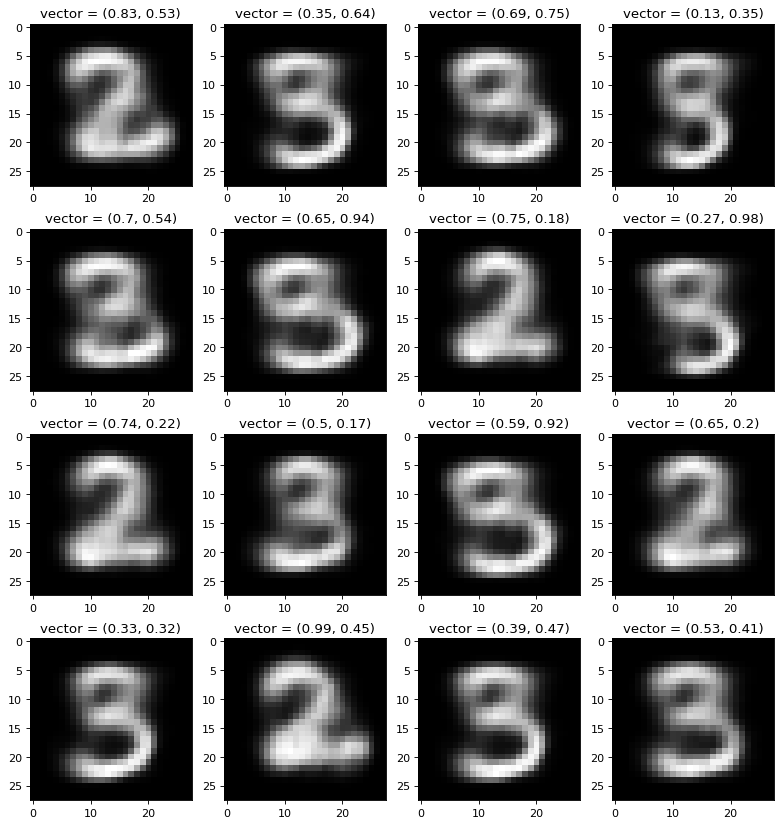

In [ ]:
# Sample a random  vector, generate fake images and plot 
fig, ax = plt.subplots(4,4,figsize = (12,13), dpi = 80)
for i, ax in enumerate(fig.axes):
  
  random_latent_vector = np.random.rand(latent_dims)
  fake_image = trained_vae_decoder.predict(random_latent_vector.reshape(1,-1))[0]

  ax.imshow(fake_image.reshape(28, 28), cmap= 'gray') 
  ax.set_title(f"vector = {round(random_latent_vector[0],2), round(random_latent_vector[1],2)}")